<a href="https://colab.research.google.com/github/stonewallmhk/QuantMindi/blob/main/ModernPortfolioTheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [12]:
# stocks to handle
stocks = ['APPL','WMT','TSLA','GE','AMZN','DB']

# Historical data
start_date = '2010-01-01'
end_date = '2017-01-01'

def download_data():
  #name of the stock (key) - stock values (2010-2017)
  stock_data = {}

  for stock in stocks:
    ticker = yf.Ticker(stock) 
    stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

  return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()



APPL: No data found for this date range, symbol may be delisted


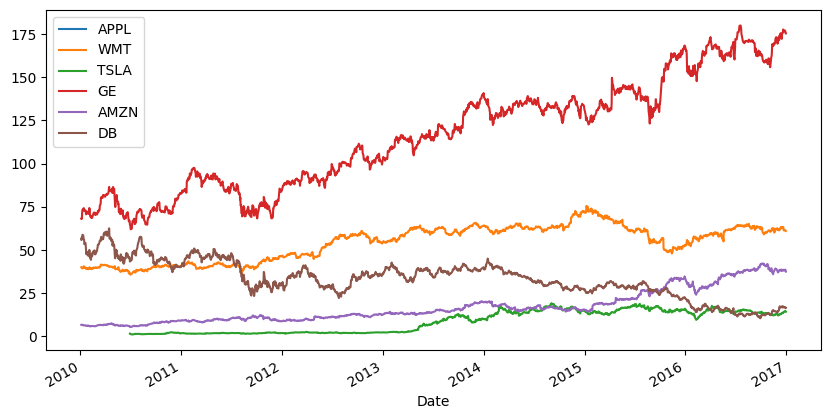

In [13]:
if __name__ =='__main__':
  dataset = download_data()
  show_data(dataset)